In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:31]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[30:60]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC )
  #images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.5,fy=0.5, interpolation = cv2.INTER_CUBIC )
  #images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


In [12]:
Dataset = 'MAP Dataset'

In [13]:

f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 3.6983532905578613 [s] ... size 913.25696 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')
'''

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [ ]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [18]:

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [01:16<00:00,  2.55s/it]


In [19]:

for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 36943.37it/s]


In [ ]:
'''
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [29]:

orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


In [30]:

for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 453438.27it/s]


In [ ]:
'''
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

In [ ]:
'''
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

In [ ]:
'''
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [31]:

start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


In [32]:

for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 98380.86it/s]


In [ ]:
'''
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [33]:

start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [01:12<00:00,  2.42s/it]


In [34]:

for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 222116.72it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [66]:

start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [06:35<00:00, 13.18s/it]


In [67]:

for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 261327.35it/s]


In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [68]:

start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


In [69]:

for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 268578.70it/s]


In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [70]:

print(len(left_files_path))

31


In [71]:

print(len(right_files_path))

30


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [72]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [03:03<00:00,  6.12s/it]


In [73]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 222509.50it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [74]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [02:37<00:00,  5.25s/it]


In [75]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 219597.07it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [76]:

class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [77]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [03:09<00:00,  6.30s/it]


In [78]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 245520.23it/s]


In [ ]:
'''
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [20]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [21]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [22]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [23]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [25]:

H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  3%|▎         | 1/31 [00:07<03:50,  7.68s/it]


Number of matches 52701
Number of matches After Lowe's Ratio 2934
Number of Robust matches 2405




  6%|▋         | 2/31 [00:16<03:48,  7.88s/it]


Number of matches 59876
Number of matches After Lowe's Ratio 2976
Number of Robust matches 2951




 10%|▉         | 3/31 [00:24<03:48,  8.18s/it]


Number of matches 61172
Number of matches After Lowe's Ratio 3650
Number of Robust matches 3325




 13%|█▎        | 4/31 [00:34<03:49,  8.51s/it]


Number of matches 66392
Number of matches After Lowe's Ratio 3869
Number of Robust matches 3596




 16%|█▌        | 5/31 [00:44<03:53,  8.97s/it]


Number of matches 72780
Number of matches After Lowe's Ratio 4305
Number of Robust matches 3548




 19%|█▉        | 6/31 [00:54<03:54,  9.36s/it]


Number of matches 74389
Number of matches After Lowe's Ratio 4434
Number of Robust matches 4325




 23%|██▎       | 7/31 [01:04<03:52,  9.70s/it]


Number of matches 76764
Number of matches After Lowe's Ratio 4882
Number of Robust matches 4798




 26%|██▌       | 8/31 [01:16<03:52, 10.11s/it]


Number of matches 83509
Number of matches After Lowe's Ratio 4603
Number of Robust matches 4370




 29%|██▉       | 9/31 [01:26<03:47, 10.36s/it]


Number of matches 78512
Number of matches After Lowe's Ratio 4207
Number of Robust matches 3794




 32%|███▏      | 10/31 [01:39<03:48, 10.90s/it]


Number of matches 95841
Number of matches After Lowe's Ratio 4037
Number of Robust matches 3388




 35%|███▌      | 11/31 [01:52<03:50, 11.52s/it]


Number of matches 97898
Number of matches After Lowe's Ratio 157
Number of Robust matches 118




 39%|███▊      | 12/31 [02:04<03:44, 11.83s/it]


Number of matches 87838
Number of matches After Lowe's Ratio 9131
Number of Robust matches 9078




 42%|████▏     | 13/31 [02:16<03:31, 11.76s/it]


Number of matches 83115
Number of matches After Lowe's Ratio 4229
Number of Robust matches 4086




 45%|████▌     | 14/31 [02:27<03:17, 11.65s/it]


Number of matches 78367
Number of matches After Lowe's Ratio 4384
Number of Robust matches 4070




 48%|████▊     | 15/31 [02:38<03:01, 11.35s/it]


Number of matches 73279
Number of matches After Lowe's Ratio 3957
Number of Robust matches 3286




 52%|█████▏    | 16/31 [02:48<02:45, 11.05s/it]


Number of matches 71592
Number of matches After Lowe's Ratio 3754
Number of Robust matches 3679




 55%|█████▍    | 17/31 [02:59<02:31, 10.85s/it]


Number of matches 70885
Number of matches After Lowe's Ratio 3637
Number of Robust matches 2987




 58%|█████▊    | 18/31 [03:09<02:20, 10.78s/it]


Number of matches 72927
Number of matches After Lowe's Ratio 3263
Number of Robust matches 3225




 61%|██████▏   | 19/31 [03:19<02:07, 10.64s/it]


Number of matches 69163
Number of matches After Lowe's Ratio 2634
Number of Robust matches 2303




 65%|██████▍   | 20/31 [03:29<01:54, 10.38s/it]


Number of matches 66808
Number of matches After Lowe's Ratio 2651
Number of Robust matches 2244




 68%|██████▊   | 21/31 [03:40<01:44, 10.40s/it]


Number of matches 78906
Number of matches After Lowe's Ratio 2211
Number of Robust matches 1995




 71%|███████   | 22/31 [03:50<01:34, 10.47s/it]


Number of matches 71699
Number of matches After Lowe's Ratio 206
Number of Robust matches 114




 74%|███████▍  | 23/31 [04:01<01:23, 10.42s/it]


Number of matches 71467
Number of matches After Lowe's Ratio 8865
Number of Robust matches 7072




 77%|███████▋  | 24/31 [04:10<01:10, 10.04s/it]


Number of matches 56848
Number of matches After Lowe's Ratio 3194
Number of Robust matches 2731




 81%|████████  | 25/31 [04:19<00:58,  9.73s/it]


Number of matches 63880
Number of matches After Lowe's Ratio 2893
Number of Robust matches 2868




 84%|████████▍ | 26/31 [04:29<00:48,  9.73s/it]


Number of matches 64991
Number of matches After Lowe's Ratio 3188
Number of Robust matches 3038




 87%|████████▋ | 27/31 [04:39<00:39,  9.81s/it]


Number of matches 70134
Number of matches After Lowe's Ratio 3285
Number of Robust matches 3104




 90%|█████████ | 28/31 [04:50<00:30, 10.27s/it]


Number of matches 81498
Number of matches After Lowe's Ratio 3255
Number of Robust matches 3214




 94%|█████████▎| 29/31 [05:01<00:20, 10.41s/it]


Number of matches 73062
Number of matches After Lowe's Ratio 446
Number of Robust matches 325




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 69252
Number of matches After Lowe's Ratio 5768
Number of Robust matches 5487




  3%|▎         | 1/30 [00:08<03:55,  8.11s/it]


Number of matches 56236
Number of matches After Lowe's Ratio 2996
Number of Robust matches 2556




  7%|▋         | 2/30 [00:16<03:46,  8.08s/it]


Number of matches 52035
Number of matches After Lowe's Ratio 2794
Number of Robust matches 2602




 10%|█         | 3/30 [00:23<03:33,  7.90s/it]


Number of matches 51662
Number of matches After Lowe's Ratio 2628
Number of Robust matches 2483



Number of matches 61491
Number of matches After Lowe's Ratio 3246
Number of Robust matches 3068



Number of matches 61191
Number of matches After Lowe's Ratio 8555


 17%|█▋        | 5/30 [00:40<03:26,  8.26s/it]

Number of Robust matches 8538




 20%|██        | 6/30 [00:49<03:21,  8.41s/it]


Number of matches 58442
Number of matches After Lowe's Ratio 139
Number of Robust matches 114




 23%|██▎       | 7/30 [00:57<03:13,  8.40s/it]


Number of matches 52121
Number of matches After Lowe's Ratio 2109
Number of Robust matches 1924




 27%|██▋       | 8/30 [01:06<03:03,  8.35s/it]


Number of matches 56414
Number of matches After Lowe's Ratio 2379
Number of Robust matches 1834




 30%|███       | 9/30 [01:14<02:56,  8.39s/it]


Number of matches 54669
Number of matches After Lowe's Ratio 2657
Number of Robust matches 2574




 33%|███▎      | 10/30 [01:22<02:47,  8.37s/it]


Number of matches 54437
Number of matches After Lowe's Ratio 2732
Number of Robust matches 2683




 37%|███▋      | 11/30 [01:30<02:36,  8.25s/it]


Number of matches 52910
Number of matches After Lowe's Ratio 2508
Number of Robust matches 2248




 40%|████      | 12/30 [01:39<02:28,  8.27s/it]


Number of matches 57190
Number of matches After Lowe's Ratio 2556
Number of Robust matches 2420




 43%|████▎     | 13/30 [01:47<02:23,  8.44s/it]


Number of matches 57107
Number of matches After Lowe's Ratio 2715
Number of Robust matches 2532




 47%|████▋     | 14/30 [01:57<02:18,  8.67s/it]


Number of matches 63309
Number of matches After Lowe's Ratio 2853
Number of Robust matches 2717




 50%|█████     | 15/30 [02:07<02:15,  9.03s/it]


Number of matches 68314
Number of matches After Lowe's Ratio 3520
Number of Robust matches 3384




 53%|█████▎    | 16/30 [02:17<02:11,  9.39s/it]


Number of matches 71061
Number of matches After Lowe's Ratio 3961
Number of Robust matches 3848




 57%|█████▋    | 17/30 [02:27<02:05,  9.68s/it]


Number of matches 73944
Number of matches After Lowe's Ratio 4469
Number of Robust matches 3927



Number of matches 79221
Number of matches After Lowe's Ratio 4490


 60%|██████    | 18/30 [02:38<02:01, 10.09s/it]

Number of Robust matches 4332




 63%|██████▎   | 19/30 [02:49<01:53, 10.32s/it]


Number of matches 77384
Number of matches After Lowe's Ratio 4682
Number of Robust matches 4150




 67%|██████▋   | 20/30 [03:00<01:46, 10.63s/it]


Number of matches 83617
Number of matches After Lowe's Ratio 4862
Number of Robust matches 4290




 70%|███████   | 21/30 [03:14<01:44, 11.57s/it]


Number of matches 84637
Number of matches After Lowe's Ratio 4621
Number of Robust matches 4463




 73%|███████▎  | 22/30 [03:28<01:38, 12.36s/it]


Number of matches 90811
Number of matches After Lowe's Ratio 4886
Number of Robust matches 4656



Number of matches 100102
Number of matches After Lowe's Ratio 4905
Number of Robust matches 4408

 77%|███████▋  | 23/30 [03:43<01:31, 13.11s/it]

 80%|████████  | 24/30 [03:58<01:22, 13.75s/it]


Number of matches 102104
Number of matches After Lowe's Ratio 4755
Number of Robust matches 4190




 83%|████████▎ | 25/30 [04:15<01:13, 14.63s/it]


Number of matches 120804
Number of matches After Lowe's Ratio 8418
Number of Robust matches 7910




 87%|████████▋ | 26/30 [04:32<01:01, 15.41s/it]


Number of matches 116085
Number of matches After Lowe's Ratio 228
Number of Robust matches 201




 90%|█████████ | 27/30 [04:50<00:47, 15.98s/it]


Number of matches 115502
Number of matches After Lowe's Ratio 2841
Number of Robust matches 2351




 93%|█████████▎| 28/30 [05:07<00:32, 16.29s/it]


Number of matches 110526
Number of matches After Lowe's Ratio 3240
Number of Robust matches 2749




 97%|█████████▋| 29/30 [05:23<00:16, 16.34s/it]


Number of matches 108812
Number of matches After Lowe's Ratio 3499
Number of Robust matches 3173




In [26]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00761866569519043 [s] ... size 0.004208 MB


In [27]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0058438777923583984 [s] ... size 0.004136 MB


In [28]:

del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:

'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [79]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  3%|▎         | 1/31 [00:17<08:50, 17.68s/it]


Number of matches 68204
Number of matches After Lowe's Ratio 13237
Number of Robust matches 12506




  6%|▋         | 2/31 [00:35<08:35, 17.77s/it]


Number of matches 67610
Number of matches After Lowe's Ratio 13819
Number of Robust matches 13672




 10%|▉         | 3/31 [00:53<08:16, 17.74s/it]


Number of matches 67944
Number of matches After Lowe's Ratio 15005
Number of Robust matches 13863




 13%|█▎        | 4/31 [01:10<07:57, 17.67s/it]


Number of matches 67779
Number of matches After Lowe's Ratio 14955
Number of Robust matches 14652




 16%|█▌        | 5/31 [01:27<07:35, 17.52s/it]


Number of matches 67209
Number of matches After Lowe's Ratio 15002
Number of Robust matches 14825




 19%|█▉        | 6/31 [01:45<07:15, 17.40s/it]


Number of matches 68745
Number of matches After Lowe's Ratio 14786
Number of Robust matches 14559



Number of matches 70174
Number of matches After Lowe's Ratio 15720


 23%|██▎       | 7/31 [02:03<07:03, 17.63s/it]

Number of Robust matches 14000




 26%|██▌       | 8/31 [02:20<06:43, 17.55s/it]


Number of matches 67151
Number of matches After Lowe's Ratio 14364
Number of Robust matches 14130




 29%|██▉       | 9/31 [02:38<06:25, 17.53s/it]


Number of matches 69682
Number of matches After Lowe's Ratio 13790
Number of Robust matches 12683




 32%|███▏      | 10/31 [02:55<06:03, 17.33s/it]


Number of matches 63496
Number of matches After Lowe's Ratio 13956
Number of Robust matches 13606




 35%|███▌      | 11/31 [03:11<05:40, 17.05s/it]


Number of matches 64953
Number of matches After Lowe's Ratio 1080
Number of Robust matches 999




 39%|███▊      | 12/31 [03:28<05:21, 16.94s/it]


Number of matches 67102
Number of matches After Lowe's Ratio 23503
Number of Robust matches 23462




 42%|████▏     | 13/31 [03:45<05:05, 16.96s/it]


Number of matches 67765
Number of matches After Lowe's Ratio 15079
Number of Robust matches 12739




 45%|████▌     | 14/31 [04:02<04:50, 17.07s/it]


Number of matches 67829
Number of matches After Lowe's Ratio 15427
Number of Robust matches 14411




 48%|████▊     | 15/31 [04:19<04:35, 17.20s/it]


Number of matches 69602
Number of matches After Lowe's Ratio 15129
Number of Robust matches 14872




 52%|█████▏    | 16/31 [04:37<04:19, 17.31s/it]


Number of matches 68540
Number of matches After Lowe's Ratio 14700
Number of Robust matches 14569




 55%|█████▍    | 17/31 [04:55<04:04, 17.44s/it]


Number of matches 69730
Number of matches After Lowe's Ratio 14191
Number of Robust matches 13881




 58%|█████▊    | 18/31 [05:12<03:47, 17.48s/it]


Number of matches 67963
Number of matches After Lowe's Ratio 13267
Number of Robust matches 12900




 61%|██████▏   | 19/31 [05:30<03:29, 17.45s/it]


Number of matches 67606
Number of matches After Lowe's Ratio 11735
Number of Robust matches 11233




 65%|██████▍   | 20/31 [05:47<03:10, 17.28s/it]


Number of matches 65351
Number of matches After Lowe's Ratio 11349
Number of Robust matches 10000




 68%|██████▊   | 21/31 [06:03<02:50, 17.06s/it]


Number of matches 59786
Number of matches After Lowe's Ratio 9966
Number of Robust matches 8925




 71%|███████   | 22/31 [06:19<02:31, 16.81s/it]


Number of matches 58969
Number of matches After Lowe's Ratio 1482
Number of Robust matches 890




 74%|███████▍  | 23/31 [06:35<02:11, 16.39s/it]


Number of matches 58867
Number of matches After Lowe's Ratio 23278
Number of Robust matches 23239




 77%|███████▋  | 24/31 [06:52<01:57, 16.75s/it]


Number of matches 66021
Number of matches After Lowe's Ratio 13415
Number of Robust matches 12206




 81%|████████  | 25/31 [07:10<01:42, 17.02s/it]


Number of matches 64815
Number of matches After Lowe's Ratio 12940
Number of Robust matches 12717




 84%|████████▍ | 26/31 [07:27<01:25, 17.05s/it]


Number of matches 67831
Number of matches After Lowe's Ratio 13386
Number of Robust matches 13269




 87%|████████▋ | 27/31 [07:45<01:08, 17.16s/it]


Number of matches 68706
Number of matches After Lowe's Ratio 13925
Number of Robust matches 13021




 90%|█████████ | 28/31 [08:01<00:51, 17.10s/it]


Number of matches 64275
Number of matches After Lowe's Ratio 13861
Number of Robust matches 13607




 94%|█████████▎| 29/31 [08:18<00:33, 16.83s/it]


Number of matches 61361
Number of matches After Lowe's Ratio 2611
Number of Robust matches 2464




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 59918
Number of matches After Lowe's Ratio 19183
Number of Robust matches 19113



Number of matches 65600
Number of matches After Lowe's Ratio 13163


  3%|▎         | 1/30 [00:17<08:14, 17.05s/it]

Number of Robust matches 12864




  7%|▋         | 2/30 [00:33<07:52, 16.89s/it]


Number of matches 67130
Number of matches After Lowe's Ratio 12598
Number of Robust matches 10568




 10%|█         | 3/30 [00:50<07:36, 16.90s/it]


Number of matches 67052
Number of matches After Lowe's Ratio 12293
Number of Robust matches 12138




 13%|█▎        | 4/30 [01:07<07:18, 16.88s/it]


Number of matches 62348
Number of matches After Lowe's Ratio 13289
Number of Robust matches 13148




 17%|█▋        | 5/30 [01:23<06:56, 16.66s/it]


Number of matches 62156
Number of matches After Lowe's Ratio 26336
Number of Robust matches 26271




 20%|██        | 6/30 [01:39<06:34, 16.43s/it]


Number of matches 61947
Number of matches After Lowe's Ratio 1051
Number of Robust matches 867




 23%|██▎       | 7/30 [01:56<06:19, 16.51s/it]


Number of matches 66232
Number of matches After Lowe's Ratio 10808
Number of Robust matches 9459




 27%|██▋       | 8/30 [02:13<06:06, 16.68s/it]


Number of matches 68003
Number of matches After Lowe's Ratio 11407
Number of Robust matches 11190




 30%|███       | 9/30 [02:30<05:53, 16.85s/it]


Number of matches 69139
Number of matches After Lowe's Ratio 12303
Number of Robust matches 12144




 33%|███▎      | 10/30 [02:48<05:43, 17.16s/it]


Number of matches 68167
Number of matches After Lowe's Ratio 12478
Number of Robust matches 12310




 37%|███▋      | 11/30 [03:05<05:25, 17.13s/it]


Number of matches 67776
Number of matches After Lowe's Ratio 12115
Number of Robust matches 11171




 40%|████      | 12/30 [03:22<05:06, 17.05s/it]


Number of matches 65978
Number of matches After Lowe's Ratio 12370
Number of Robust matches 10974




 43%|████▎     | 13/30 [03:39<04:51, 17.14s/it]


Number of matches 68384
Number of matches After Lowe's Ratio 12507
Number of Robust matches 11607




 47%|████▋     | 14/30 [03:56<04:34, 17.18s/it]


Number of matches 67195
Number of matches After Lowe's Ratio 12575
Number of Robust matches 12124




 50%|█████     | 15/30 [04:14<04:17, 17.20s/it]


Number of matches 70522
Number of matches After Lowe's Ratio 13190
Number of Robust matches 12707




 53%|█████▎    | 16/30 [04:31<04:01, 17.28s/it]


Number of matches 70525
Number of matches After Lowe's Ratio 14083
Number of Robust matches 13944




 57%|█████▋    | 17/30 [04:49<03:45, 17.35s/it]


Number of matches 71367
Number of matches After Lowe's Ratio 14462
Number of Robust matches 13281




 60%|██████    | 18/30 [05:06<03:28, 17.41s/it]


Number of matches 70355
Number of matches After Lowe's Ratio 14335
Number of Robust matches 11381



Number of matches 72339
Number of matches After Lowe's Ratio 14493


 63%|██████▎   | 19/30 [05:24<03:13, 17.55s/it]

Number of Robust matches 13446




 67%|██████▋   | 20/30 [05:41<02:55, 17.54s/it]


Number of matches 71008
Number of matches After Lowe's Ratio 14580
Number of Robust matches 14384



Number of matches 73619
Number of matches After Lowe's Ratio 14701


 70%|███████   | 21/30 [06:00<02:39, 17.75s/it]

Number of Robust matches 14268



Number of matches 73150
Number of matches After Lowe's Ratio 14669


 73%|███████▎  | 22/30 [06:18<02:23, 17.95s/it]

Number of Robust matches 14183




 77%|███████▋  | 23/30 [06:36<02:05, 17.93s/it]


Number of matches 71973
Number of matches After Lowe's Ratio 14677
Number of Robust matches 14048



Number of matches 75769
Number of matches After Lowe's Ratio 13715


 80%|████████  | 24/30 [06:54<01:48, 18.04s/it]

Number of Robust matches 11907




 83%|████████▎ | 25/30 [07:12<01:30, 18.01s/it]


Number of matches 70483
Number of matches After Lowe's Ratio 21735
Number of Robust matches 20397




 87%|████████▋ | 26/30 [07:29<01:10, 17.72s/it]


Number of matches 66793
Number of matches After Lowe's Ratio 1461
Number of Robust matches 1160




 90%|█████████ | 27/30 [07:47<00:53, 17.71s/it]


Number of matches 71612
Number of matches After Lowe's Ratio 11326
Number of Robust matches 8758




 93%|█████████▎| 28/30 [08:05<00:35, 17.83s/it]


Number of matches 71931
Number of matches After Lowe's Ratio 11467
Number of Robust matches 10386




 97%|█████████▋| 29/30 [08:24<00:18, 18.10s/it]


Number of matches 71394
Number of matches After Lowe's Ratio 11920
Number of Robust matches 10515




In [80]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008863210678100586 [s] ... size 0.004208 MB


In [81]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004171848297119141 [s] ... size 0.004136 MB


In [82]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [35]:

H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  3%|▎         | 1/31 [00:01<00:34,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 792
Number of Robust matches 714




  6%|▋         | 2/31 [00:02<00:34,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 703
Number of Robust matches 565




 10%|▉         | 3/31 [00:03<00:32,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 841
Number of Robust matches 770




 13%|█▎        | 4/31 [00:04<00:30,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 870
Number of Robust matches 634




 16%|█▌        | 5/31 [00:05<00:28,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 940
Number of Robust matches 857




 19%|█▉        | 6/31 [00:06<00:27,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 961
Number of Robust matches 776




 23%|██▎       | 7/31 [00:07<00:26,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 986
Number of Robust matches 886




 26%|██▌       | 8/31 [00:08<00:25,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 930
Number of Robust matches 743




 29%|██▉       | 9/31 [00:09<00:24,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 904
Number of Robust matches 718




 32%|███▏      | 10/31 [00:11<00:22,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 805
Number of Robust matches 725




 35%|███▌      | 11/31 [00:12<00:23,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 67
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1569
Number of Robust matches New 6




 39%|███▊      | 12/31 [00:13<00:21,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1687
Number of Robust matches 1627




 42%|████▏     | 13/31 [00:14<00:20,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 914
Number of Robust matches 822




 45%|████▌     | 14/31 [00:15<00:18,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 965
Number of Robust matches 893




 48%|████▊     | 15/31 [00:16<00:17,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 883
Number of Robust matches 735




 52%|█████▏    | 16/31 [00:17<00:16,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 803
Number of Robust matches 675




 55%|█████▍    | 17/31 [00:18<00:15,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 847
Number of Robust matches 769




 58%|█████▊    | 18/31 [00:20<00:14,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 771
Number of Robust matches 689




 61%|██████▏   | 19/31 [00:21<00:13,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 607
Number of Robust matches 508




 65%|██████▍   | 20/31 [00:22<00:12,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 671
Number of Robust matches 431




 68%|██████▊   | 21/31 [00:23<00:11,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 577
Number of Robust matches 501




 71%|███████   | 22/31 [00:24<00:10,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 139
Number of Robust matches 48




 74%|███████▍  | 23/31 [00:25<00:08,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2563
Number of Robust matches 2337




 77%|███████▋  | 24/31 [00:26<00:07,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1011
Number of Robust matches 916




 81%|████████  | 25/31 [00:27<00:06,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 859
Number of Robust matches 733




 84%|████████▍ | 26/31 [00:28<00:05,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 898
Number of Robust matches 829




 87%|████████▋ | 27/31 [00:30<00:04,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 867
Number of Robust matches 799




 90%|█████████ | 28/31 [00:31<00:03,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 675
Number of Robust matches 590




 94%|█████████▎| 29/31 [00:32<00:02,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 154
Number of Robust matches 91




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 1274
Number of Robust matches 994




  3%|▎         | 1/30 [00:01<00:30,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 839
Number of Robust matches 746




  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 816
Number of Robust matches 702




 10%|█         | 3/30 [00:03<00:29,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 780
Number of Robust matches 700




 13%|█▎        | 4/30 [00:04<00:28,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 814
Number of Robust matches 650




 17%|█▋        | 5/30 [00:05<00:28,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2106
Number of Robust matches 2029




 20%|██        | 6/30 [00:06<00:28,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 90
Number of Robust matches 14


Number of matches After Lowe's Ratio New 1614
Number of Robust matches New 7




 23%|██▎       | 7/30 [00:07<00:26,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 474
Number of Robust matches 344




 27%|██▋       | 8/30 [00:08<00:24,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 607
Number of Robust matches 509




 30%|███       | 9/30 [00:10<00:24,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 672
Number of Robust matches 572




 33%|███▎      | 10/30 [00:11<00:22,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 797
Number of Robust matches 693




 37%|███▋      | 11/30 [00:12<00:21,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 744
Number of Robust matches 619




 40%|████      | 12/30 [00:13<00:19,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 691
Number of Robust matches 564




 43%|████▎     | 13/30 [00:14<00:18,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 670
Number of Robust matches 564




 47%|████▋     | 14/30 [00:15<00:18,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 614
Number of Robust matches 517




 50%|█████     | 15/30 [00:16<00:16,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 773
Number of Robust matches 640




 53%|█████▎    | 16/30 [00:17<00:15,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 909
Number of Robust matches 767




 57%|█████▋    | 17/30 [00:19<00:14,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 887
Number of Robust matches 787




 60%|██████    | 18/30 [00:20<00:13,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 793
Number of Robust matches 731




 63%|██████▎   | 19/30 [00:21<00:12,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 989
Number of Robust matches 894




 67%|██████▋   | 20/30 [00:22<00:11,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1039
Number of Robust matches 943




 70%|███████   | 21/30 [00:23<00:10,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 773
Number of Robust matches 682




 73%|███████▎  | 22/30 [00:24<00:08,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 781
Number of Robust matches 686




 77%|███████▋  | 23/30 [00:25<00:07,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 699
Number of Robust matches 568




 80%|████████  | 24/30 [00:27<00:06,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 464
Number of Robust matches 330




 83%|████████▎ | 25/30 [00:28<00:05,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 719
Number of Robust matches 457




 87%|████████▋ | 26/30 [00:29<00:04,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 78
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1575
Number of Robust matches New 6




 90%|█████████ | 27/30 [00:30<00:03,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 130
Number of Robust matches 31




 93%|█████████▎| 28/30 [00:31<00:02,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 172
Number of Robust matches 76




 97%|█████████▋| 29/30 [00:32<00:01,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 244
Number of Robust matches 135




In [36]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005062580108642578 [s] ... size 0.004208 MB


In [37]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0073397159576416016 [s] ... size 0.004136 MB


In [38]:

del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [39]:

H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  3%|▎         | 1/31 [00:00<00:15,  1.98it/s]


Number of matches 11640
Number of matches After Lowe's Ratio 2642
Number of Robust matches 2438




  6%|▋         | 2/31 [00:01<00:14,  1.99it/s]


Number of matches 12471
Number of matches After Lowe's Ratio 2780
Number of Robust matches 2579




 10%|▉         | 3/31 [00:01<00:14,  1.94it/s]


Number of matches 13081
Number of matches After Lowe's Ratio 3173
Number of Robust matches 2924




 13%|█▎        | 4/31 [00:02<00:14,  1.89it/s]


Number of matches 13737
Number of matches After Lowe's Ratio 3412
Number of Robust matches 3227




 16%|█▌        | 5/31 [00:02<00:15,  1.68it/s]


Number of matches 14217
Number of matches After Lowe's Ratio 3666
Number of Robust matches 3305




 19%|█▉        | 6/31 [00:03<00:15,  1.63it/s]


Number of matches 15183
Number of matches After Lowe's Ratio 3699
Number of Robust matches 3059




 23%|██▎       | 7/31 [00:04<00:15,  1.58it/s]


Number of matches 15490
Number of matches After Lowe's Ratio 3915
Number of Robust matches 3253




 26%|██▌       | 8/31 [00:04<00:14,  1.54it/s]


Number of matches 15182
Number of matches After Lowe's Ratio 3588
Number of Robust matches 3348




 29%|██▉       | 9/31 [00:05<00:14,  1.52it/s]


Number of matches 15597
Number of matches After Lowe's Ratio 3337
Number of Robust matches 3117




 32%|███▏      | 10/31 [00:06<00:14,  1.41it/s]


Number of matches 14492
Number of matches After Lowe's Ratio 349
Number of Robust matches 130




 35%|███▌      | 11/31 [00:07<00:14,  1.36it/s]


Number of matches 15781
Number of matches After Lowe's Ratio 253
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1534
Number of Robust matches New 5




 39%|███▊      | 12/31 [00:07<00:13,  1.37it/s]


Number of matches 15996
Number of matches After Lowe's Ratio 6164
Number of Robust matches 6036




 42%|████▏     | 13/31 [00:08<00:12,  1.39it/s]


Number of matches 15586
Number of matches After Lowe's Ratio 3592
Number of Robust matches 3255




 45%|████▌     | 14/31 [00:09<00:12,  1.39it/s]


Number of matches 15101
Number of matches After Lowe's Ratio 3697
Number of Robust matches 3486




 48%|████▊     | 15/31 [00:10<00:12,  1.32it/s]


Number of matches 14997
Number of matches After Lowe's Ratio 3409
Number of Robust matches 3126




 52%|█████▏    | 16/31 [00:10<00:10,  1.37it/s]


Number of matches 14445
Number of matches After Lowe's Ratio 3333
Number of Robust matches 3043




 55%|█████▍    | 17/31 [00:11<00:09,  1.42it/s]


Number of matches 14392
Number of matches After Lowe's Ratio 3155
Number of Robust matches 2993




 58%|█████▊    | 18/31 [00:12<00:08,  1.48it/s]


Number of matches 13731
Number of matches After Lowe's Ratio 2943
Number of Robust matches 2765




 61%|██████▏   | 19/31 [00:12<00:07,  1.54it/s]


Number of matches 12824
Number of matches After Lowe's Ratio 2396
Number of Robust matches 2151




 65%|██████▍   | 20/31 [00:13<00:06,  1.63it/s]


Number of matches 11566
Number of matches After Lowe's Ratio 2131
Number of Robust matches 1783




 68%|██████▊   | 21/31 [00:13<00:05,  1.75it/s]


Number of matches 10801
Number of matches After Lowe's Ratio 317
Number of Robust matches 125




 71%|███████   | 22/31 [00:14<00:05,  1.62it/s]


Number of matches 9720
Number of matches After Lowe's Ratio 170
Number of Robust matches 5


Number of matches After Lowe's Ratio New 992
Number of Robust matches New 5




 74%|███████▍  | 23/31 [00:14<00:04,  1.79it/s]


Number of matches 9650
Number of matches After Lowe's Ratio 4558
Number of Robust matches 4454




 77%|███████▋  | 24/31 [00:15<00:03,  1.94it/s]


Number of matches 11030
Number of matches After Lowe's Ratio 2488
Number of Robust matches 2343




 81%|████████  | 25/31 [00:15<00:02,  2.01it/s]


Number of matches 12044
Number of matches After Lowe's Ratio 2646
Number of Robust matches 2445




 84%|████████▍ | 26/31 [00:16<00:02,  1.97it/s]


Number of matches 13307
Number of matches After Lowe's Ratio 2850
Number of Robust matches 2521




 87%|████████▋ | 27/31 [00:16<00:02,  1.89it/s]


Number of matches 14421
Number of matches After Lowe's Ratio 3005
Number of Robust matches 2803




 90%|█████████ | 28/31 [00:17<00:01,  1.79it/s]


Number of matches 14073
Number of matches After Lowe's Ratio 417
Number of Robust matches 185




 94%|█████████▎| 29/31 [00:18<00:01,  1.52it/s]


Number of matches 12065
Number of matches After Lowe's Ratio 209
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1230
Number of Robust matches New 6




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 11195
Number of matches After Lowe's Ratio 2200
Number of Robust matches 2048




  3%|▎         | 1/30 [00:00<00:14,  2.05it/s]


Number of matches 11062
Number of matches After Lowe's Ratio 2547
Number of Robust matches 1909




  7%|▋         | 2/30 [00:00<00:13,  2.08it/s]


Number of matches 11226
Number of matches After Lowe's Ratio 2324
Number of Robust matches 1748




 10%|█         | 3/30 [00:01<00:12,  2.08it/s]


Number of matches 11174
Number of matches After Lowe's Ratio 2318
Number of Robust matches 2011




 13%|█▎        | 4/30 [00:01<00:12,  2.08it/s]


Number of matches 10340
Number of matches After Lowe's Ratio 2529
Number of Robust matches 2255




 17%|█▋        | 5/30 [00:02<00:11,  2.10it/s]


Number of matches 10294
Number of matches After Lowe's Ratio 4709
Number of Robust matches 4252




 20%|██        | 6/30 [00:02<00:12,  1.97it/s]


Number of matches 9563
Number of matches After Lowe's Ratio 183
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1001
Number of Robust matches New 6




 23%|██▎       | 7/30 [00:03<00:11,  1.94it/s]


Number of matches 10847
Number of matches After Lowe's Ratio 297
Number of Robust matches 126




 27%|██▋       | 8/30 [00:03<00:11,  2.00it/s]


Number of matches 11792
Number of matches After Lowe's Ratio 2168
Number of Robust matches 1591




 30%|███       | 9/30 [00:04<00:10,  2.02it/s]


Number of matches 11961
Number of matches After Lowe's Ratio 2534
Number of Robust matches 2236




 33%|███▎      | 10/30 [00:04<00:10,  1.99it/s]


Number of matches 11802
Number of matches After Lowe's Ratio 2552
Number of Robust matches 2381




 37%|███▋      | 11/30 [00:05<00:09,  1.98it/s]


Number of matches 11223
Number of matches After Lowe's Ratio 2455
Number of Robust matches 2218




 40%|████      | 12/30 [00:05<00:08,  2.01it/s]


Number of matches 11057
Number of matches After Lowe's Ratio 2221
Number of Robust matches 2069




 43%|████▎     | 13/30 [00:06<00:08,  2.02it/s]


Number of matches 11676
Number of matches After Lowe's Ratio 2309
Number of Robust matches 2104




 47%|████▋     | 14/30 [00:06<00:08,  1.99it/s]


Number of matches 12158
Number of matches After Lowe's Ratio 2436
Number of Robust matches 2152




 50%|█████     | 15/30 [00:07<00:08,  1.79it/s]


Number of matches 13755
Number of matches After Lowe's Ratio 2870
Number of Robust matches 2648




 53%|█████▎    | 16/30 [00:08<00:07,  1.76it/s]


Number of matches 14320
Number of matches After Lowe's Ratio 3249
Number of Robust matches 2991




 57%|█████▋    | 17/30 [00:08<00:07,  1.67it/s]


Number of matches 14845
Number of matches After Lowe's Ratio 3508
Number of Robust matches 2809




 60%|██████    | 18/30 [00:09<00:07,  1.62it/s]


Number of matches 15208
Number of matches After Lowe's Ratio 3417
Number of Robust matches 3193




 63%|██████▎   | 19/30 [00:10<00:07,  1.57it/s]


Number of matches 15693
Number of matches After Lowe's Ratio 3700
Number of Robust matches 3338




 67%|██████▋   | 20/30 [00:11<00:07,  1.42it/s]


Number of matches 15580
Number of matches After Lowe's Ratio 3583
Number of Robust matches 3038




 70%|███████   | 21/30 [00:11<00:06,  1.42it/s]


Number of matches 17006
Number of matches After Lowe's Ratio 3636
Number of Robust matches 3074




 73%|███████▎  | 22/30 [00:12<00:06,  1.29it/s]


Number of matches 17533
Number of matches After Lowe's Ratio 3978
Number of Robust matches 3620




 77%|███████▋  | 23/30 [00:13<00:05,  1.21it/s]


Number of matches 17597
Number of matches After Lowe's Ratio 3707
Number of Robust matches 3331




 80%|████████  | 24/30 [00:14<00:05,  1.15it/s]


Number of matches 19214
Number of matches After Lowe's Ratio 3488
Number of Robust matches 3207




 83%|████████▎ | 25/30 [00:15<00:04,  1.03it/s]


Number of matches 18825
Number of matches After Lowe's Ratio 5617
Number of Robust matches 5168




 87%|████████▋ | 26/30 [00:17<00:04,  1.03s/it]


Number of matches 19333
Number of matches After Lowe's Ratio 334
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2045
Number of Robust matches New 5




 90%|█████████ | 27/30 [00:18<00:03,  1.06s/it]


Number of matches 20851
Number of matches After Lowe's Ratio 545
Number of Robust matches 114




 93%|█████████▎| 28/30 [00:19<00:02,  1.09s/it]


Number of matches 20815
Number of matches After Lowe's Ratio 2902
Number of Robust matches 2280




 97%|█████████▋| 29/30 [00:20<00:01,  1.15s/it]


Number of matches 20258
Number of matches After Lowe's Ratio 3216
Number of Robust matches 2646




In [40]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005183219909667969 [s] ... size 0.004208 MB


In [41]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007928848266601562 [s] ... size 0.004136 MB


In [42]:

del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [43]:

H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  3%|▎         | 1/31 [00:06<03:19,  6.66s/it]


Number of matches 50821
Number of matches After Lowe's Ratio 1561
Number of Robust matches 1449




  6%|▋         | 2/31 [00:13<03:18,  6.84s/it]


Number of matches 57635
Number of matches After Lowe's Ratio 1621
Number of Robust matches 1584




 10%|▉         | 3/31 [00:21<03:19,  7.14s/it]


Number of matches 58829
Number of matches After Lowe's Ratio 1942
Number of Robust matches 1915




 13%|█▎        | 4/31 [00:30<03:23,  7.55s/it]


Number of matches 63609
Number of matches After Lowe's Ratio 2057
Number of Robust matches 2030




 16%|█▌        | 5/31 [00:39<03:30,  8.08s/it]


Number of matches 70003
Number of matches After Lowe's Ratio 2327
Number of Robust matches 2260




 19%|█▉        | 6/31 [00:49<03:34,  8.56s/it]


Number of matches 71459
Number of matches After Lowe's Ratio 2256
Number of Robust matches 2175




 23%|██▎       | 7/31 [00:59<03:34,  8.92s/it]


Number of matches 73438
Number of matches After Lowe's Ratio 2471
Number of Robust matches 2426




 26%|██▌       | 8/31 [01:08<03:31,  9.20s/it]


Number of matches 80152
Number of matches After Lowe's Ratio 2235
Number of Robust matches 2069




 29%|██▉       | 9/31 [01:19<03:30,  9.55s/it]


Number of matches 75512
Number of matches After Lowe's Ratio 2078
Number of Robust matches 2015




 32%|███▏      | 10/31 [01:30<03:29,  9.96s/it]


Number of matches 92127
Number of matches After Lowe's Ratio 1720
Number of Robust matches 1623




 35%|███▌      | 11/31 [01:42<03:34, 10.72s/it]


Number of matches 94658
Number of matches After Lowe's Ratio 136
Number of Robust matches 65




 39%|███▊      | 12/31 [01:54<03:31, 11.13s/it]


Number of matches 84877
Number of matches After Lowe's Ratio 4524
Number of Robust matches 4479




 42%|████▏     | 13/31 [02:05<03:18, 11.05s/it]


Number of matches 80087
Number of matches After Lowe's Ratio 2187
Number of Robust matches 2097




 45%|████▌     | 14/31 [02:15<03:04, 10.83s/it]


Number of matches 75535
Number of matches After Lowe's Ratio 2235
Number of Robust matches 2018




 48%|████▊     | 15/31 [02:25<02:49, 10.57s/it]


Number of matches 70697
Number of matches After Lowe's Ratio 2093
Number of Robust matches 2048




 52%|█████▏    | 16/31 [02:35<02:33, 10.20s/it]


Number of matches 69251
Number of matches After Lowe's Ratio 2009
Number of Robust matches 1937




 55%|█████▍    | 17/31 [02:44<02:19,  9.96s/it]


Number of matches 68288
Number of matches After Lowe's Ratio 1832
Number of Robust matches 1698




 58%|█████▊    | 18/31 [02:54<02:07,  9.81s/it]


Number of matches 70362
Number of matches After Lowe's Ratio 1612
Number of Robust matches 1581




 61%|██████▏   | 19/31 [03:03<01:56,  9.73s/it]


Number of matches 66626
Number of matches After Lowe's Ratio 1385
Number of Robust matches 1340




 65%|██████▍   | 20/31 [03:12<01:44,  9.53s/it]


Number of matches 64311
Number of matches After Lowe's Ratio 1392
Number of Robust matches 1210




 68%|██████▊   | 21/31 [03:22<01:36,  9.61s/it]


Number of matches 75963
Number of matches After Lowe's Ratio 1123
Number of Robust matches 1068




 71%|███████   | 22/31 [03:32<01:27,  9.77s/it]


Number of matches 69127
Number of matches After Lowe's Ratio 138
Number of Robust matches 69




 74%|███████▍  | 23/31 [03:42<01:17,  9.75s/it]


Number of matches 68881
Number of matches After Lowe's Ratio 4274
Number of Robust matches 4244




 77%|███████▋  | 24/31 [03:51<01:06,  9.45s/it]


Number of matches 55094
Number of matches After Lowe's Ratio 1549
Number of Robust matches 1411




 81%|████████  | 25/31 [03:59<00:54,  9.11s/it]


Number of matches 61771
Number of matches After Lowe's Ratio 1512
Number of Robust matches 1446




 84%|████████▍ | 26/31 [04:07<00:44,  8.90s/it]


Number of matches 62561
Number of matches After Lowe's Ratio 1689
Number of Robust matches 1660




 87%|████████▋ | 27/31 [04:16<00:35,  8.84s/it]


Number of matches 67741
Number of matches After Lowe's Ratio 1780
Number of Robust matches 1663




 90%|█████████ | 28/31 [04:26<00:27,  9.14s/it]


Number of matches 78402
Number of matches After Lowe's Ratio 1600
Number of Robust matches 1571




 94%|█████████▎| 29/31 [04:36<00:18,  9.34s/it]


Number of matches 70521
Number of matches After Lowe's Ratio 261
Number of Robust matches 194




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 66566
Number of matches After Lowe's Ratio 3004
Number of Robust matches 2963




  3%|▎         | 1/30 [00:06<03:18,  6.84s/it]


Number of matches 54204
Number of matches After Lowe's Ratio 1597
Number of Robust matches 1433




  7%|▋         | 2/30 [00:13<03:13,  6.90s/it]


Number of matches 50359
Number of matches After Lowe's Ratio 1515
Number of Robust matches 1483




 10%|█         | 3/30 [00:20<03:03,  6.78s/it]


Number of matches 49695
Number of matches After Lowe's Ratio 1332
Number of Robust matches 1296




 13%|█▎        | 4/30 [00:27<02:59,  6.91s/it]


Number of matches 59507
Number of matches After Lowe's Ratio 1622
Number of Robust matches 1585




 17%|█▋        | 5/30 [00:35<03:02,  7.29s/it]


Number of matches 59147
Number of matches After Lowe's Ratio 4341
Number of Robust matches 4281




 20%|██        | 6/30 [00:43<02:58,  7.43s/it]


Number of matches 56222
Number of matches After Lowe's Ratio 93
Number of Robust matches 52




 23%|██▎       | 7/30 [00:50<02:50,  7.42s/it]


Number of matches 50439
Number of matches After Lowe's Ratio 986
Number of Robust matches 940




 27%|██▋       | 8/30 [00:57<02:40,  7.32s/it]


Number of matches 54422
Number of matches After Lowe's Ratio 1284
Number of Robust matches 1210




 30%|███       | 9/30 [01:05<02:35,  7.39s/it]


Number of matches 52619
Number of matches After Lowe's Ratio 1415
Number of Robust matches 1240




 33%|███▎      | 10/30 [01:12<02:26,  7.34s/it]


Number of matches 52450
Number of matches After Lowe's Ratio 1476
Number of Robust matches 1426




 37%|███▋      | 11/30 [01:19<02:17,  7.24s/it]


Number of matches 51064
Number of matches After Lowe's Ratio 1391
Number of Robust matches 1298




 40%|████      | 12/30 [01:27<02:10,  7.24s/it]


Number of matches 55140
Number of matches After Lowe's Ratio 1432
Number of Robust matches 1400




 43%|████▎     | 13/30 [01:34<02:03,  7.25s/it]


Number of matches 55069
Number of matches After Lowe's Ratio 1403
Number of Robust matches 1355




 47%|████▋     | 14/30 [01:42<01:58,  7.42s/it]


Number of matches 61141
Number of matches After Lowe's Ratio 1553
Number of Robust matches 1511




 50%|█████     | 15/30 [01:50<01:56,  7.77s/it]


Number of matches 65938
Number of matches After Lowe's Ratio 1773
Number of Robust matches 1741




 53%|█████▎    | 16/30 [01:59<01:53,  8.14s/it]


Number of matches 68556
Number of matches After Lowe's Ratio 1989
Number of Robust matches 1919




 57%|█████▋    | 17/30 [02:08<01:49,  8.44s/it]


Number of matches 71096
Number of matches After Lowe's Ratio 2251
Number of Robust matches 2206




 60%|██████    | 18/30 [02:18<01:46,  8.84s/it]


Number of matches 76287
Number of matches After Lowe's Ratio 2185
Number of Robust matches 2116




 63%|██████▎   | 19/30 [02:28<01:40,  9.14s/it]


Number of matches 74400
Number of matches After Lowe's Ratio 2290
Number of Robust matches 2243




 67%|██████▋   | 20/30 [02:38<01:34,  9.44s/it]


Number of matches 80493
Number of matches After Lowe's Ratio 2343
Number of Robust matches 2183




 70%|███████   | 21/30 [02:49<01:28,  9.83s/it]


Number of matches 81191
Number of matches After Lowe's Ratio 2284
Number of Robust matches 2151




 73%|███████▎  | 22/30 [03:00<01:21, 10.16s/it]


Number of matches 87211
Number of matches After Lowe's Ratio 2506
Number of Robust matches 2437




 77%|███████▋  | 23/30 [03:12<01:15, 10.74s/it]


Number of matches 95895
Number of matches After Lowe's Ratio 2457
Number of Robust matches 2240




 80%|████████  | 24/30 [03:24<01:07, 11.19s/it]


Number of matches 97673
Number of matches After Lowe's Ratio 2376
Number of Robust matches 2253




 83%|████████▎ | 25/30 [03:38<00:59, 11.88s/it]


Number of matches 115825
Number of matches After Lowe's Ratio 4331
Number of Robust matches 4065




 87%|████████▋ | 26/30 [03:52<00:50, 12.74s/it]


Number of matches 111993
Number of matches After Lowe's Ratio 187
Number of Robust matches 102




 90%|█████████ | 27/30 [04:07<00:39, 13.23s/it]


Number of matches 111424
Number of matches After Lowe's Ratio 1349
Number of Robust matches 1070




 93%|█████████▎| 28/30 [04:21<00:26, 13.48s/it]


Number of matches 106599
Number of matches After Lowe's Ratio 1728
Number of Robust matches 1459




 97%|█████████▋| 29/30 [04:34<00:13, 13.49s/it]


Number of matches 104785
Number of matches After Lowe's Ratio 1822
Number of Robust matches 1667




In [44]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0041582584381103516 [s] ... size 0.004208 MB


In [45]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00405120849609375 [s] ... size 0.004136 MB


In [46]:

del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [84]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  3%|▎         | 1/31 [00:11<05:35, 11.17s/it]


Number of matches 78076
Number of matches After Lowe's Ratio 13359
Number of Robust matches 12552




  6%|▋         | 2/31 [00:22<05:25, 11.23s/it]


Number of matches 80714
Number of matches After Lowe's Ratio 13814
Number of Robust matches 13653



Number of matches 80336
Number of matches After Lowe's Ratio 14791


 10%|▉         | 3/31 [00:34<05:17, 11.33s/it]

Number of Robust matches 14628



Number of matches 81730
Number of matches After Lowe's Ratio 15028


 13%|█▎        | 4/31 [00:45<05:06, 11.36s/it]

Number of Robust matches 14270




 16%|█▌        | 5/31 [00:57<04:57, 11.45s/it]


Number of matches 83405
Number of matches After Lowe's Ratio 15534
Number of Robust matches 14640




 19%|█▉        | 6/31 [01:08<04:45, 11.42s/it]


Number of matches 83689
Number of matches After Lowe's Ratio 14606
Number of Robust matches 12778




 23%|██▎       | 7/31 [01:19<04:32, 11.34s/it]


Number of matches 84685
Number of matches After Lowe's Ratio 15675
Number of Robust matches 13576




 26%|██▌       | 8/31 [01:31<04:21, 11.38s/it]


Number of matches 87247
Number of matches After Lowe's Ratio 14213
Number of Robust matches 13631




 29%|██▉       | 9/31 [01:42<04:10, 11.40s/it]


Number of matches 86271
Number of matches After Lowe's Ratio 12670
Number of Robust matches 11350




 32%|███▏      | 10/31 [01:54<04:01, 11.49s/it]


Number of matches 92521
Number of matches After Lowe's Ratio 168
Number of Robust matches 119



Number of matches 89028
Number of matches After Lowe's Ratio 17
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4921


 35%|███▌      | 11/31 [02:06<03:52, 11.64s/it]

Number of Robust matches New 7




 39%|███▊      | 12/31 [02:18<03:42, 11.69s/it]


Number of matches 85791
Number of matches After Lowe's Ratio 26730
Number of Robust matches 26600



Number of matches 83757
Number of matches After Lowe's Ratio 14339


 42%|████▏     | 13/31 [02:29<03:31, 11.75s/it]

Number of Robust matches 14095



Number of matches 82139
Number of matches After Lowe's Ratio 15134


 45%|████▌     | 14/31 [02:41<03:18, 11.65s/it]

Number of Robust matches 14756




 48%|████▊     | 15/31 [02:52<03:04, 11.54s/it]


Number of matches 80490
Number of matches After Lowe's Ratio 14815
Number of Robust matches 13170



Number of matches 80977
Number of matches After Lowe's Ratio 14288


 52%|█████▏    | 16/31 [03:03<02:51, 11.43s/it]

Number of Robust matches 13988




 55%|█████▍    | 17/31 [03:15<02:39, 11.37s/it]


Number of matches 81532
Number of matches After Lowe's Ratio 14173
Number of Robust matches 12017




 58%|█████▊    | 18/31 [03:26<02:28, 11.39s/it]


Number of matches 82215
Number of matches After Lowe's Ratio 13119
Number of Robust matches 12989




 61%|██████▏   | 19/31 [03:37<02:16, 11.37s/it]


Number of matches 81724
Number of matches After Lowe's Ratio 11981
Number of Robust matches 10303




 65%|██████▍   | 20/31 [03:49<02:04, 11.36s/it]


Number of matches 82166
Number of matches After Lowe's Ratio 11603
Number of Robust matches 10453




 68%|██████▊   | 21/31 [04:00<01:53, 11.32s/it]


Number of matches 87861
Number of matches After Lowe's Ratio 299
Number of Robust matches 212



Number of matches 86177
Number of matches After Lowe's Ratio 16
Number of Robust matches 4


Number of matches After Lowe's Ratio New 5174


 71%|███████   | 22/31 [04:12<01:44, 11.63s/it]

Number of Robust matches New 8



Number of matches 86058
Number of matches After Lowe's Ratio 30380


 74%|███████▍  | 23/31 [04:24<01:33, 11.72s/it]

Number of Robust matches 28421




 77%|███████▋  | 24/31 [04:35<01:21, 11.58s/it]


Number of matches 79476
Number of matches After Lowe's Ratio 14230
Number of Robust matches 14084




 81%|████████  | 25/31 [04:46<01:08, 11.36s/it]


Number of matches 80362
Number of matches After Lowe's Ratio 13368
Number of Robust matches 12838




 84%|████████▍ | 26/31 [04:57<00:55, 11.16s/it]


Number of matches 78799
Number of matches After Lowe's Ratio 13668
Number of Robust matches 13556




 87%|████████▋ | 27/31 [05:08<00:44, 11.01s/it]


Number of matches 79330
Number of matches After Lowe's Ratio 13114
Number of Robust matches 11474




 90%|█████████ | 28/31 [05:18<00:32, 10.90s/it]


Number of matches 83632
Number of matches After Lowe's Ratio 338
Number of Robust matches 304



Number of matches 80615
Number of matches After Lowe's Ratio 21
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4621


 94%|█████████▎| 29/31 [05:29<00:21, 10.91s/it]

Number of Robust matches New 6




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 80631
Number of matches After Lowe's Ratio 10550
Number of Robust matches 9536




  3%|▎         | 1/30 [00:10<05:04, 10.50s/it]


Number of matches 79867
Number of matches After Lowe's Ratio 13145
Number of Robust matches 12882




  7%|▋         | 2/30 [00:21<04:55, 10.55s/it]


Number of matches 77978
Number of matches After Lowe's Ratio 12492
Number of Robust matches 11956




 10%|█         | 3/30 [00:31<04:45, 10.56s/it]


Number of matches 77277
Number of matches After Lowe's Ratio 11984
Number of Robust matches 11376



Number of matches 80615
Number of matches After Lowe's Ratio 13824


 13%|█▎        | 4/30 [00:42<04:37, 10.69s/it]

Number of Robust matches 13687



Number of matches 80421
Number of matches After Lowe's Ratio 29352


 17%|█▋        | 5/30 [00:53<04:29, 10.80s/it]

Number of Robust matches 29246



Number of matches 77858
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 4384


 20%|██        | 6/30 [01:04<04:18, 10.78s/it]

Number of Robust matches New 6




 23%|██▎       | 7/30 [01:14<04:00, 10.46s/it]


Number of matches 73979
Number of matches After Lowe's Ratio 271
Number of Robust matches 223




 27%|██▋       | 8/30 [01:24<03:48, 10.38s/it]


Number of matches 75451
Number of matches After Lowe's Ratio 10850
Number of Robust matches 10119




 30%|███       | 9/30 [01:34<03:36, 10.31s/it]


Number of matches 75366
Number of matches After Lowe's Ratio 11830
Number of Robust matches 11103




 33%|███▎      | 10/30 [01:44<03:25, 10.30s/it]


Number of matches 76689
Number of matches After Lowe's Ratio 12229
Number of Robust matches 12085




 37%|███▋      | 11/30 [01:55<03:15, 10.31s/it]


Number of matches 76921
Number of matches After Lowe's Ratio 12167
Number of Robust matches 11368



Number of matches 78784
Number of matches After Lowe's Ratio 12203


 40%|████      | 12/30 [02:05<03:07, 10.41s/it]

Number of Robust matches 12006



Number of matches 78589
Number of matches After Lowe's Ratio 12406


 43%|████▎     | 13/30 [02:16<02:57, 10.45s/it]

Number of Robust matches 12287



Number of matches 79964
Number of matches After Lowe's Ratio 12770


 47%|████▋     | 14/30 [02:27<02:48, 10.53s/it]

Number of Robust matches 12560




 50%|█████     | 15/30 [02:37<02:38, 10.54s/it]


Number of matches 79492
Number of matches After Lowe's Ratio 12781
Number of Robust matches 12415




 53%|█████▎    | 16/30 [02:48<02:28, 10.63s/it]


Number of matches 81474
Number of matches After Lowe's Ratio 13378
Number of Robust matches 12943




 57%|█████▋    | 17/30 [02:59<02:19, 10.72s/it]


Number of matches 82783
Number of matches After Lowe's Ratio 13925
Number of Robust matches 13612




 60%|██████    | 18/30 [03:10<02:10, 10.85s/it]


Number of matches 84853
Number of matches After Lowe's Ratio 13789
Number of Robust matches 13513




 63%|██████▎   | 19/30 [03:21<02:01, 11.02s/it]


Number of matches 84436
Number of matches After Lowe's Ratio 13802
Number of Robust matches 13255




 67%|██████▋   | 20/30 [03:33<01:51, 11.16s/it]


Number of matches 86145
Number of matches After Lowe's Ratio 14372
Number of Robust matches 13715




 70%|███████   | 21/30 [03:44<01:41, 11.26s/it]


Number of matches 84838
Number of matches After Lowe's Ratio 13742
Number of Robust matches 13006




 73%|███████▎  | 22/30 [03:56<01:30, 11.29s/it]


Number of matches 85894
Number of matches After Lowe's Ratio 13886
Number of Robust matches 13639



Number of matches 87900
Number of matches After Lowe's Ratio 14002


 77%|███████▋  | 23/30 [04:08<01:20, 11.45s/it]

Number of Robust matches 13738




 80%|████████  | 24/30 [04:19<01:08, 11.47s/it]


Number of matches 85888
Number of matches After Lowe's Ratio 13203
Number of Robust matches 11667




 83%|████████▎ | 25/30 [04:31<00:57, 11.56s/it]


Number of matches 90873
Number of matches After Lowe's Ratio 23329
Number of Robust matches 21836



Number of matches 83723
Number of matches After Lowe's Ratio 35
Number of Robust matches 10


Number of matches After Lowe's Ratio New 4866
Number of Robust matches New 16




 90%|█████████ | 27/30 [04:53<00:34, 11.34s/it]


Number of matches 81750
Number of matches After Lowe's Ratio 271
Number of Robust matches 178




 93%|█████████▎| 28/30 [05:04<00:22, 11.19s/it]


Number of matches 82671
Number of matches After Lowe's Ratio 9500
Number of Robust matches 9029




 97%|█████████▋| 29/30 [05:15<00:11, 11.08s/it]


Number of matches 82854
Number of matches After Lowe's Ratio 10216
Number of Robust matches 9386




In [85]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0055081844329833984 [s] ... size 0.004208 MB


In [86]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006522417068481445 [s] ... size 0.004136 MB


In [87]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [88]:

H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  3%|▎         | 1/31 [00:17<08:56, 17.88s/it]


Number of matches 68204
Number of matches After Lowe's Ratio 19021
Number of Robust matches 14884




  6%|▋         | 2/31 [00:34<08:30, 17.61s/it]


Number of matches 67610
Number of matches After Lowe's Ratio 19503
Number of Robust matches 15860




 10%|▉         | 3/31 [00:51<08:03, 17.28s/it]


Number of matches 67944
Number of matches After Lowe's Ratio 20679
Number of Robust matches 16069




 13%|█▎        | 4/31 [01:07<07:41, 17.08s/it]


Number of matches 67779
Number of matches After Lowe's Ratio 20627
Number of Robust matches 17049



Number of matches 67209
Number of matches After Lowe's Ratio 20676


 16%|█▌        | 5/31 [01:24<07:23, 17.04s/it]

Number of Robust matches 14977




 19%|█▉        | 6/31 [01:41<07:05, 17.01s/it]


Number of matches 68745
Number of matches After Lowe's Ratio 20616
Number of Robust matches 16804



Number of matches 70174
Number of matches After Lowe's Ratio 21597


 23%|██▎       | 7/31 [02:00<06:57, 17.40s/it]

Number of Robust matches 17892




 26%|██▌       | 8/31 [02:17<06:40, 17.43s/it]


Number of matches 67151
Number of matches After Lowe's Ratio 19631
Number of Robust matches 16030



Number of matches 69682
Number of matches After Lowe's Ratio 19815


 29%|██▉       | 9/31 [02:34<06:22, 17.37s/it]

Number of Robust matches 16157




 32%|███▏      | 10/31 [02:51<05:58, 17.07s/it]


Number of matches 63496
Number of matches After Lowe's Ratio 18597
Number of Robust matches 14083




 35%|███▌      | 11/31 [03:07<05:37, 16.89s/it]


Number of matches 64953
Number of matches After Lowe's Ratio 6202
Number of Robust matches 1731




 39%|███▊      | 12/31 [03:24<05:18, 16.74s/it]


Number of matches 67102
Number of matches After Lowe's Ratio 28236
Number of Robust matches 25241




 42%|████▏     | 13/31 [03:40<05:00, 16.71s/it]


Number of matches 67765
Number of matches After Lowe's Ratio 20805
Number of Robust matches 17260




 45%|████▌     | 14/31 [03:57<04:43, 16.68s/it]


Number of matches 67829
Number of matches After Lowe's Ratio 21071
Number of Robust matches 17533




 48%|████▊     | 15/31 [04:14<04:28, 16.80s/it]


Number of matches 69602
Number of matches After Lowe's Ratio 20988
Number of Robust matches 17096




 52%|█████▏    | 16/31 [04:31<04:14, 16.97s/it]


Number of matches 68540
Number of matches After Lowe's Ratio 20405
Number of Robust matches 16436




 55%|█████▍    | 17/31 [04:49<03:59, 17.09s/it]


Number of matches 69730
Number of matches After Lowe's Ratio 20166
Number of Robust matches 15489




 58%|█████▊    | 18/31 [05:06<03:42, 17.13s/it]


Number of matches 67963
Number of matches After Lowe's Ratio 19005
Number of Robust matches 15061




 61%|██████▏   | 19/31 [05:23<03:24, 17.05s/it]


Number of matches 67606
Number of matches After Lowe's Ratio 17536
Number of Robust matches 12201



Number of matches 65351
Number of matches After Lowe's Ratio 16878


 65%|██████▍   | 20/31 [05:40<03:07, 17.00s/it]

Number of Robust matches 13093




 68%|██████▊   | 21/31 [05:55<02:45, 16.57s/it]


Number of matches 59786
Number of matches After Lowe's Ratio 14638
Number of Robust matches 10764




 71%|███████   | 22/31 [06:11<02:25, 16.22s/it]


Number of matches 58969
Number of matches After Lowe's Ratio 5472
Number of Robust matches 1378




 74%|███████▍  | 23/31 [06:26<02:08, 16.04s/it]


Number of matches 58867
Number of matches After Lowe's Ratio 26840
Number of Robust matches 24596




 77%|███████▋  | 24/31 [06:43<01:52, 16.11s/it]


Number of matches 66021
Number of matches After Lowe's Ratio 19001
Number of Robust matches 15475




 81%|████████  | 25/31 [06:59<01:37, 16.30s/it]


Number of matches 64815
Number of matches After Lowe's Ratio 18370
Number of Robust matches 15018




 84%|████████▍ | 26/31 [07:16<01:21, 16.35s/it]


Number of matches 67831
Number of matches After Lowe's Ratio 19360
Number of Robust matches 15736



Number of matches 68706
Number of matches After Lowe's Ratio 19921


 87%|████████▋ | 27/31 [07:33<01:06, 16.69s/it]

Number of Robust matches 16125




 90%|█████████ | 28/31 [07:50<00:49, 16.63s/it]


Number of matches 64275
Number of matches After Lowe's Ratio 19099
Number of Robust matches 15665




 94%|█████████▎| 29/31 [08:05<00:32, 16.36s/it]


Number of matches 61361
Number of matches After Lowe's Ratio 7455
Number of Robust matches 2939




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 59918
Number of matches After Lowe's Ratio 23437
Number of Robust matches 20701




  3%|▎         | 1/30 [00:16<08:02, 16.65s/it]


Number of matches 65600
Number of matches After Lowe's Ratio 18680
Number of Robust matches 14568




  7%|▋         | 2/30 [00:33<07:44, 16.60s/it]


Number of matches 67130
Number of matches After Lowe's Ratio 18413
Number of Robust matches 14106




 10%|█         | 3/30 [00:49<07:26, 16.55s/it]


Number of matches 67052
Number of matches After Lowe's Ratio 18167
Number of Robust matches 14439




 13%|█▎        | 4/30 [01:05<07:05, 16.36s/it]


Number of matches 62348
Number of matches After Lowe's Ratio 18390
Number of Robust matches 15156




 17%|█▋        | 5/30 [01:21<06:45, 16.20s/it]


Number of matches 62156
Number of matches After Lowe's Ratio 29731
Number of Robust matches 25692




 20%|██        | 6/30 [01:36<06:24, 16.01s/it]


Number of matches 61947
Number of matches After Lowe's Ratio 5704
Number of Robust matches 1371



Number of matches 66232
Number of matches After Lowe's Ratio 16574


 23%|██▎       | 7/30 [01:53<06:10, 16.10s/it]

Number of Robust matches 12648




 27%|██▋       | 8/30 [02:09<05:57, 16.24s/it]


Number of matches 68003
Number of matches After Lowe's Ratio 17507
Number of Robust matches 12953



Number of matches 69139
Number of matches After Lowe's Ratio 18546


 30%|███       | 9/30 [02:27<05:49, 16.65s/it]

Number of Robust matches 14648




 33%|███▎      | 10/30 [02:43<05:32, 16.62s/it]


Number of matches 68167
Number of matches After Lowe's Ratio 18393
Number of Robust matches 14558



Number of matches 67776
Number of matches After Lowe's Ratio 18455


 37%|███▋      | 11/30 [03:00<05:16, 16.68s/it]

Number of Robust matches 14230




 40%|████      | 12/30 [03:16<04:57, 16.52s/it]


Number of matches 65978
Number of matches After Lowe's Ratio 18204
Number of Robust matches 14481




 43%|████▎     | 13/30 [03:33<04:42, 16.60s/it]


Number of matches 68384
Number of matches After Lowe's Ratio 18777
Number of Robust matches 14331



Number of matches 67195
Number of matches After Lowe's Ratio 18673


 47%|████▋     | 14/30 [03:50<04:28, 16.77s/it]

Number of Robust matches 14711




 50%|█████     | 15/30 [04:07<04:11, 16.79s/it]


Number of matches 70522
Number of matches After Lowe's Ratio 19306
Number of Robust matches 15416



Number of matches 70525
Number of matches After Lowe's Ratio 19976


 53%|█████▎    | 16/30 [04:25<03:58, 17.07s/it]

Number of Robust matches 14895




 57%|█████▋    | 17/30 [04:42<03:43, 17.18s/it]


Number of matches 71367
Number of matches After Lowe's Ratio 20585
Number of Robust matches 16486



Number of matches 70355
Number of matches After Lowe's Ratio 20456


 60%|██████    | 18/30 [05:00<03:28, 17.34s/it]

Number of Robust matches 16543



Number of matches 72339
Number of matches After Lowe's Ratio 20880


 63%|██████▎   | 19/30 [05:18<03:12, 17.48s/it]

Number of Robust matches 15896




 67%|██████▋   | 20/30 [05:35<02:54, 17.48s/it]


Number of matches 71008
Number of matches After Lowe's Ratio 20608
Number of Robust matches 16783



Number of matches 73619
Number of matches After Lowe's Ratio 21212


 70%|███████   | 21/30 [05:54<02:39, 17.77s/it]

Number of Robust matches 16292



Number of matches 73150
Number of matches After Lowe's Ratio 21161


 73%|███████▎  | 22/30 [06:12<02:23, 17.95s/it]

Number of Robust matches 16749




 77%|███████▋  | 23/30 [06:30<02:04, 17.81s/it]


Number of matches 71973
Number of matches After Lowe's Ratio 20884
Number of Robust matches 16064



Number of matches 75769
Number of matches After Lowe's Ratio 20467


 80%|████████  | 24/30 [06:48<01:48, 18.01s/it]

Number of Robust matches 15618




 83%|████████▎ | 25/30 [07:06<01:30, 18.10s/it]


Number of matches 70483
Number of matches After Lowe's Ratio 26584
Number of Robust matches 20431




 87%|████████▋ | 26/30 [07:24<01:11, 17.86s/it]


Number of matches 66793
Number of matches After Lowe's Ratio 6586
Number of Robust matches 1897




 90%|█████████ | 27/30 [07:41<00:53, 17.72s/it]


Number of matches 71612
Number of matches After Lowe's Ratio 17666
Number of Robust matches 12043




 93%|█████████▎| 28/30 [07:59<00:35, 17.85s/it]


Number of matches 71931
Number of matches After Lowe's Ratio 18002
Number of Robust matches 10943




 97%|█████████▋| 29/30 [08:17<00:17, 17.82s/it]


Number of matches 71394
Number of matches After Lowe's Ratio 18440
Number of Robust matches 12608




In [89]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00878453254699707 [s] ... size 0.004208 MB


In [90]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010860443115234375 [s] ... size 0.004136 MB


In [91]:

del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [93]:

H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  6%|▋         | 2/31 [00:00<00:03,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 215



Number of matches 1000
Number of matches After Lowe's Ratio 259
Number of Robust matches 173




 13%|█▎        | 4/31 [00:00<00:02,  9.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 220



Number of matches 1000
Number of matches After Lowe's Ratio 305
Number of Robust matches 235




 23%|██▎       | 7/31 [00:00<00:02,  9.49it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 254



Number of matches 1000
Number of matches After Lowe's Ratio 298
Number of Robust matches 272



Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 339




 29%|██▉       | 9/31 [00:00<00:02,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 321



Number of matches 1000
Number of matches After Lowe's Ratio 356
Number of Robust matches 310




 32%|███▏      | 10/31 [00:01<00:02,  8.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 270



Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 5


Number of matches After Lowe's Ratio New 38


 39%|███▊      | 12/31 [00:01<00:02,  7.39it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 474
Number of Robust matches 437




 45%|████▌     | 14/31 [00:01<00:02,  7.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 304



Number of matches 1000
Number of matches After Lowe's Ratio 347
Number of Robust matches 324




 52%|█████▏    | 16/31 [00:01<00:01,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 341
Number of Robust matches 307



Number of matches 1000
Number of matches After Lowe's Ratio 335
Number of Robust matches 288




 58%|█████▊    | 18/31 [00:02<00:01,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 350
Number of Robust matches 250



Number of matches 1000
Number of matches After Lowe's Ratio 327
Number of Robust matches 223




 65%|██████▍   | 20/31 [00:02<00:01,  8.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 256
Number of Robust matches 186



Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 253




 68%|██████▊   | 21/31 [00:02<00:01,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 218



Number of matches 1000
Number of matches After Lowe's Ratio 43
Number of Robust matches 6


Number of matches After Lowe's Ratio New 43


 74%|███████▍  | 23/31 [00:02<00:01,  7.13it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 684
Number of Robust matches 678




 77%|███████▋  | 24/31 [00:02<00:00,  7.62it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 394
Number of Robust matches 320



Number of matches 1000
Number of matches After Lowe's Ratio 372
Number of Robust matches 241




 87%|████████▋ | 27/31 [00:03<00:00,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 357
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 276




 90%|█████████ | 28/31 [00:03<00:00,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 328
Number of Robust matches 297



Number of matches 1000
Number of matches After Lowe's Ratio 31
Number of Robust matches 6


Number of matches After Lowe's Ratio New 31


  0%|          | 0/30 [00:00<?, ?it/s]

Number of Robust matches New 6



Number of matches 1000
Number of matches After Lowe's Ratio 476
Number of Robust matches 413




  7%|▋         | 2/30 [00:00<00:03,  9.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 336
Number of Robust matches 287



Number of matches 1000
Number of matches After Lowe's Ratio 366
Number of Robust matches 296




 13%|█▎        | 4/30 [00:00<00:02,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 325
Number of Robust matches 270



Number of matches 1000
Number of matches After Lowe's Ratio 285
Number of Robust matches 212




 17%|█▋        | 5/30 [00:00<00:02,  9.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 606
Number of Robust matches 488



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 5


Number of matches After Lowe's Ratio New 29


 23%|██▎       | 7/30 [00:00<00:03,  7.50it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 195
Number of Robust matches 93




 30%|███       | 9/30 [00:01<00:02,  8.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 154



Number of matches 1000
Number of matches After Lowe's Ratio 270
Number of Robust matches 170




 37%|███▋      | 11/30 [00:01<00:02,  8.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 310
Number of Robust matches 241



Number of matches 1000
Number of matches After Lowe's Ratio 336
Number of Robust matches 306




 43%|████▎     | 13/30 [00:01<00:02,  8.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 338
Number of Robust matches 304



Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 237




 50%|█████     | 15/30 [00:01<00:01,  8.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 185



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 165




 57%|█████▋    | 17/30 [00:02<00:01,  8.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 205



Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 196




 63%|██████▎   | 19/30 [00:02<00:01,  8.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 223



Number of matches 1000
Number of matches After Lowe's Ratio 309
Number of Robust matches 258




 70%|███████   | 21/30 [00:02<00:01,  8.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 287
Number of Robust matches 247



Number of matches 1000
Number of matches After Lowe's Ratio 240
Number of Robust matches 207




 77%|███████▋  | 23/30 [00:02<00:00,  8.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 246
Number of Robust matches 162



Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 104




 83%|████████▎ | 25/30 [00:02<00:00,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 75



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 257




 87%|████████▋ | 26/30 [00:03<00:00,  6.74it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 56
Number of Robust matches 5


Number of matches After Lowe's Ratio New 56
Number of Robust matches New 5




 90%|█████████ | 27/30 [00:03<00:00,  7.31it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 161
Number of Robust matches 71



Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 95




 97%|█████████▋| 29/30 [00:03<00:00,  7.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 115




In [94]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006989240646362305 [s] ... size 0.004208 MB


In [95]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006824970245361328 [s] ... size 0.004136 MB


In [96]:

del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [97]:

H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  3%|▎         | 1/31 [00:01<00:45,  1.53s/it]


Number of matches 8213
Number of matches After Lowe's Ratio 4001
Number of Robust matches 1690




  6%|▋         | 2/31 [00:02<00:42,  1.48s/it]


Number of matches 8313
Number of matches After Lowe's Ratio 3895
Number of Robust matches 1880




 10%|▉         | 3/31 [00:04<00:41,  1.47s/it]


Number of matches 8355
Number of matches After Lowe's Ratio 3947
Number of Robust matches 1996




 13%|█▎        | 4/31 [00:05<00:39,  1.46s/it]


Number of matches 8515
Number of matches After Lowe's Ratio 3898
Number of Robust matches 1819




 16%|█▌        | 5/31 [00:07<00:37,  1.45s/it]


Number of matches 8679
Number of matches After Lowe's Ratio 3886
Number of Robust matches 1843




 19%|█▉        | 6/31 [00:08<00:37,  1.49s/it]


Number of matches 8997
Number of matches After Lowe's Ratio 3927
Number of Robust matches 2035




 23%|██▎       | 7/31 [00:10<00:36,  1.52s/it]


Number of matches 9338
Number of matches After Lowe's Ratio 4048
Number of Robust matches 2100




 26%|██▌       | 8/31 [00:12<00:36,  1.60s/it]


Number of matches 9300
Number of matches After Lowe's Ratio 3823
Number of Robust matches 1684




 29%|██▉       | 9/31 [00:13<00:36,  1.66s/it]


Number of matches 9254
Number of matches After Lowe's Ratio 3943
Number of Robust matches 1713




 32%|███▏      | 10/31 [00:15<00:35,  1.68s/it]


Number of matches 9459
Number of matches After Lowe's Ratio 3823
Number of Robust matches 1679




 35%|███▌      | 11/31 [00:17<00:33,  1.70s/it]


Number of matches 8864
Number of matches After Lowe's Ratio 1516
Number of Robust matches 100




 39%|███▊      | 12/31 [00:19<00:31,  1.67s/it]


Number of matches 9066
Number of matches After Lowe's Ratio 5311
Number of Robust matches 2700




 42%|████▏     | 13/31 [00:20<00:29,  1.64s/it]


Number of matches 8704
Number of matches After Lowe's Ratio 3844
Number of Robust matches 1772




 45%|████▌     | 14/31 [00:22<00:27,  1.62s/it]


Number of matches 8501
Number of matches After Lowe's Ratio 4193
Number of Robust matches 1905




 48%|████▊     | 15/31 [00:23<00:25,  1.60s/it]


Number of matches 8368
Number of matches After Lowe's Ratio 4183
Number of Robust matches 2137




 52%|█████▏    | 16/31 [00:25<00:23,  1.57s/it]


Number of matches 8573
Number of matches After Lowe's Ratio 4284
Number of Robust matches 2367




 55%|█████▍    | 17/31 [00:26<00:22,  1.57s/it]


Number of matches 8793
Number of matches After Lowe's Ratio 4441
Number of Robust matches 2110




 58%|█████▊    | 18/31 [00:28<00:20,  1.60s/it]


Number of matches 8655
Number of matches After Lowe's Ratio 4515
Number of Robust matches 2416




 61%|██████▏   | 19/31 [00:30<00:19,  1.59s/it]


Number of matches 8488
Number of matches After Lowe's Ratio 4140
Number of Robust matches 2029




 65%|██████▍   | 20/31 [00:31<00:17,  1.56s/it]


Number of matches 8403
Number of matches After Lowe's Ratio 4089
Number of Robust matches 1845




 68%|██████▊   | 21/31 [00:33<00:15,  1.55s/it]


Number of matches 8454
Number of matches After Lowe's Ratio 2824
Number of Robust matches 1026




 71%|███████   | 22/31 [00:34<00:14,  1.57s/it]


Number of matches 8034
Number of matches After Lowe's Ratio 1531
Number of Robust matches 22


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 8




 74%|███████▍  | 23/31 [00:36<00:12,  1.51s/it]


Number of matches 8142
Number of matches After Lowe's Ratio 5360
Number of Robust matches 3227




 77%|███████▋  | 24/31 [00:37<00:10,  1.48s/it]


Number of matches 8410
Number of matches After Lowe's Ratio 4365
Number of Robust matches 1843




 81%|████████  | 25/31 [00:38<00:08,  1.46s/it]


Number of matches 8383
Number of matches After Lowe's Ratio 4177
Number of Robust matches 1969




 84%|████████▍ | 26/31 [00:40<00:07,  1.49s/it]


Number of matches 8138
Number of matches After Lowe's Ratio 3983
Number of Robust matches 2201




 87%|████████▋ | 27/31 [00:41<00:05,  1.48s/it]


Number of matches 8368
Number of matches After Lowe's Ratio 4253
Number of Robust matches 1968




 90%|█████████ | 28/31 [00:43<00:04,  1.48s/it]


Number of matches 8477
Number of matches After Lowe's Ratio 3454
Number of Robust matches 1575




 94%|█████████▎| 29/31 [00:44<00:02,  1.48s/it]


Number of matches 7747
Number of matches After Lowe's Ratio 1665
Number of Robust matches 103




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 7575
Number of matches After Lowe's Ratio 4174
Number of Robust matches 2199




  3%|▎         | 1/30 [00:01<00:40,  1.41s/it]


Number of matches 8428
Number of matches After Lowe's Ratio 3993
Number of Robust matches 2125




  7%|▋         | 2/30 [00:02<00:39,  1.41s/it]


Number of matches 8223
Number of matches After Lowe's Ratio 3944
Number of Robust matches 1738




 10%|█         | 3/30 [00:04<00:38,  1.42s/it]


Number of matches 8051
Number of matches After Lowe's Ratio 3550
Number of Robust matches 1561




 13%|█▎        | 4/30 [00:05<00:36,  1.42s/it]


Number of matches 7512
Number of matches After Lowe's Ratio 3652
Number of Robust matches 1767




 17%|█▋        | 5/30 [00:07<00:34,  1.39s/it]


Number of matches 7652
Number of matches After Lowe's Ratio 5089
Number of Robust matches 3189




 20%|██        | 6/30 [00:08<00:33,  1.39s/it]


Number of matches 6859
Number of matches After Lowe's Ratio 1441
Number of Robust matches 24


Number of matches After Lowe's Ratio New 81
Number of Robust matches New 12




 23%|██▎       | 7/30 [00:09<00:31,  1.36s/it]


Number of matches 7063
Number of matches After Lowe's Ratio 2750
Number of Robust matches 1322




 27%|██▋       | 8/30 [00:10<00:28,  1.31s/it]


Number of matches 7394
Number of matches After Lowe's Ratio 3368
Number of Robust matches 1734




 30%|███       | 9/30 [00:12<00:27,  1.31s/it]


Number of matches 7711
Number of matches After Lowe's Ratio 3671
Number of Robust matches 1815




 33%|███▎      | 10/30 [00:13<00:26,  1.33s/it]


Number of matches 7921
Number of matches After Lowe's Ratio 3627
Number of Robust matches 1770




 37%|███▋      | 11/30 [00:14<00:25,  1.34s/it]


Number of matches 7737
Number of matches After Lowe's Ratio 3373
Number of Robust matches 1591




 40%|████      | 12/30 [00:16<00:24,  1.35s/it]


Number of matches 7641
Number of matches After Lowe's Ratio 3665
Number of Robust matches 1738




 43%|████▎     | 13/30 [00:17<00:22,  1.34s/it]


Number of matches 7683
Number of matches After Lowe's Ratio 3710
Number of Robust matches 1741




 47%|████▋     | 14/30 [00:19<00:21,  1.36s/it]


Number of matches 7854
Number of matches After Lowe's Ratio 3464
Number of Robust matches 1948




 50%|█████     | 15/30 [00:20<00:20,  1.38s/it]


Number of matches 8258
Number of matches After Lowe's Ratio 3664
Number of Robust matches 1760




 53%|█████▎    | 16/30 [00:21<00:19,  1.39s/it]


Number of matches 8551
Number of matches After Lowe's Ratio 3738
Number of Robust matches 1784




 57%|█████▋    | 17/30 [00:23<00:19,  1.46s/it]


Number of matches 8894
Number of matches After Lowe's Ratio 3741
Number of Robust matches 1969




 60%|██████    | 18/30 [00:25<00:17,  1.50s/it]


Number of matches 9182
Number of matches After Lowe's Ratio 3477
Number of Robust matches 1394




 63%|██████▎   | 19/30 [00:26<00:16,  1.54s/it]


Number of matches 9450
Number of matches After Lowe's Ratio 3677
Number of Robust matches 1757




 67%|██████▋   | 20/30 [00:28<00:16,  1.60s/it]


Number of matches 9361
Number of matches After Lowe's Ratio 3675
Number of Robust matches 1866




 70%|███████   | 21/30 [00:30<00:14,  1.65s/it]


Number of matches 9314
Number of matches After Lowe's Ratio 3586
Number of Robust matches 1861




 73%|███████▎  | 22/30 [00:31<00:13,  1.66s/it]


Number of matches 9092
Number of matches After Lowe's Ratio 3676
Number of Robust matches 1735




 77%|███████▋  | 23/30 [00:33<00:11,  1.66s/it]


Number of matches 9186
Number of matches After Lowe's Ratio 3717
Number of Robust matches 1551




 80%|████████  | 24/30 [00:35<00:10,  1.69s/it]


Number of matches 8913
Number of matches After Lowe's Ratio 3556
Number of Robust matches 1533




 83%|████████▎ | 25/30 [00:36<00:08,  1.67s/it]


Number of matches 8979
Number of matches After Lowe's Ratio 5001
Number of Robust matches 2181




 87%|████████▋ | 26/30 [00:38<00:06,  1.65s/it]


Number of matches 7429
Number of matches After Lowe's Ratio 1163
Number of Robust matches 27




 90%|█████████ | 27/30 [00:39<00:04,  1.54s/it]


Number of matches 7671
Number of matches After Lowe's Ratio 2880
Number of Robust matches 854




 93%|█████████▎| 28/30 [00:41<00:02,  1.48s/it]


Number of matches 7921
Number of matches After Lowe's Ratio 3513
Number of Robust matches 1127




 97%|█████████▋| 29/30 [00:42<00:01,  1.44s/it]


Number of matches 8108
Number of matches After Lowe's Ratio 3381
Number of Robust matches 1204




In [98]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004514217376708984 [s] ... size 0.004208 MB


In [99]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0024809837341308594 [s] ... size 0.004136 MB


In [100]:

del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [102]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 9

In [106]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_freak + num_kps_gftt + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_star + num_kps_surf, 'Detector/Descriptor':['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['GFTT+SIFT']*len_files +  ['MSER+SIFT']*len_files + ['ORB']*len_files +['RootSIFT']*len_files +['SIFT']*len_files + ['STAR+BRIEF']*len_files + ['SURF']*len_files }
df_numkey_9 = pd.DataFrame(data=d)
df_numkey_9['Number of Keypoints'] = df_numkey_9['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

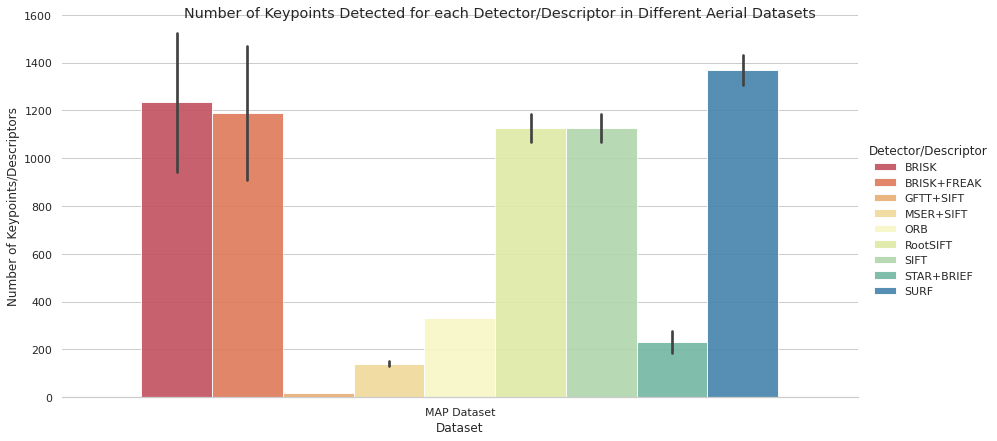

In [107]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_9, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [108]:
df_numkey_9.to_csv(f'drive/MyDrive/Num_Kypoints_9_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [110]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_freak + num_matches_gftt + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_surf, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) +  ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1) +['SIFT']*(len_files-1) + ['STAR+BRIEF']*(len_files-1) + ['SURF']*(len_files-1)  }
df_match_9 = pd.DataFrame(data=d)
df_match_9['Number of Total Matches'] = df_match_9['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

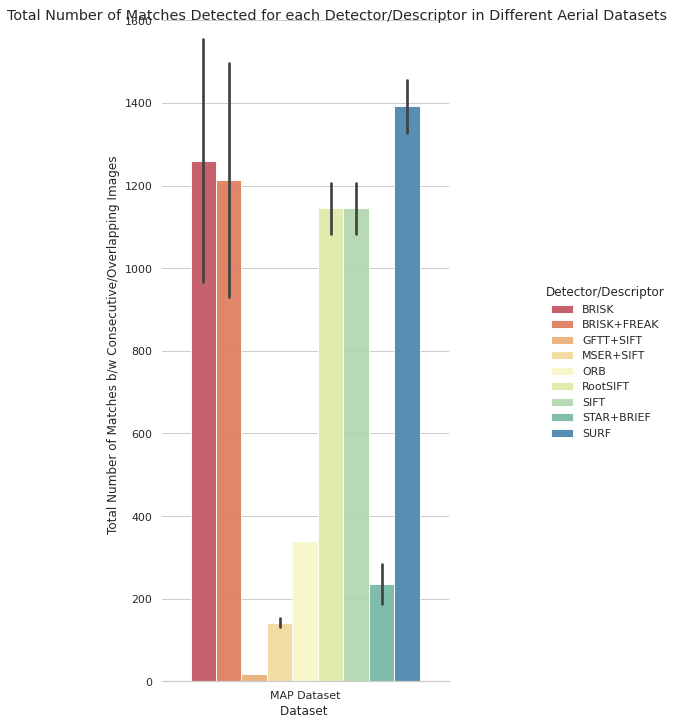

In [111]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [112]:
df_match_9['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_freak + num_good_matches_gftt +  num_good_matches_mser + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_sift + num_good_matches_briefstar + num_good_matches_surf
df_match_9['Number of Good Matches'] = df_match_9['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

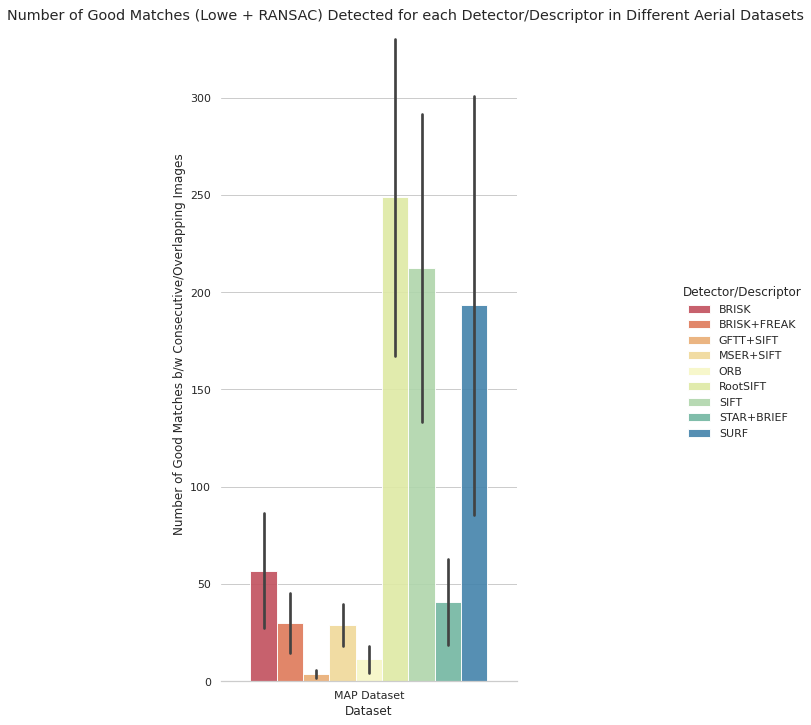

In [113]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_6.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [114]:
df_match_9['Recall Rate of Matches'] = df_match_9['Number of Good Matches']/df_match_9['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

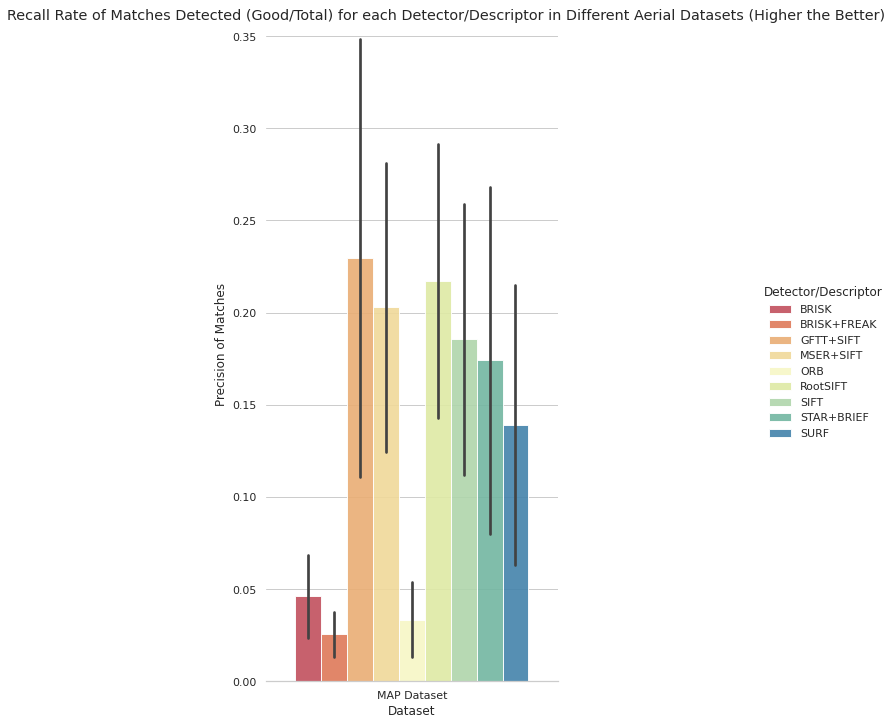

In [115]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_6.png')

1-Precision Rate for each Detector+Descriptor

In [116]:
df_match_9['1 - Precision Rate of Matches'] = (df_match_9['Number of Total Matches'] - df_match_9['Number of Good Matches'])/df_match_9['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

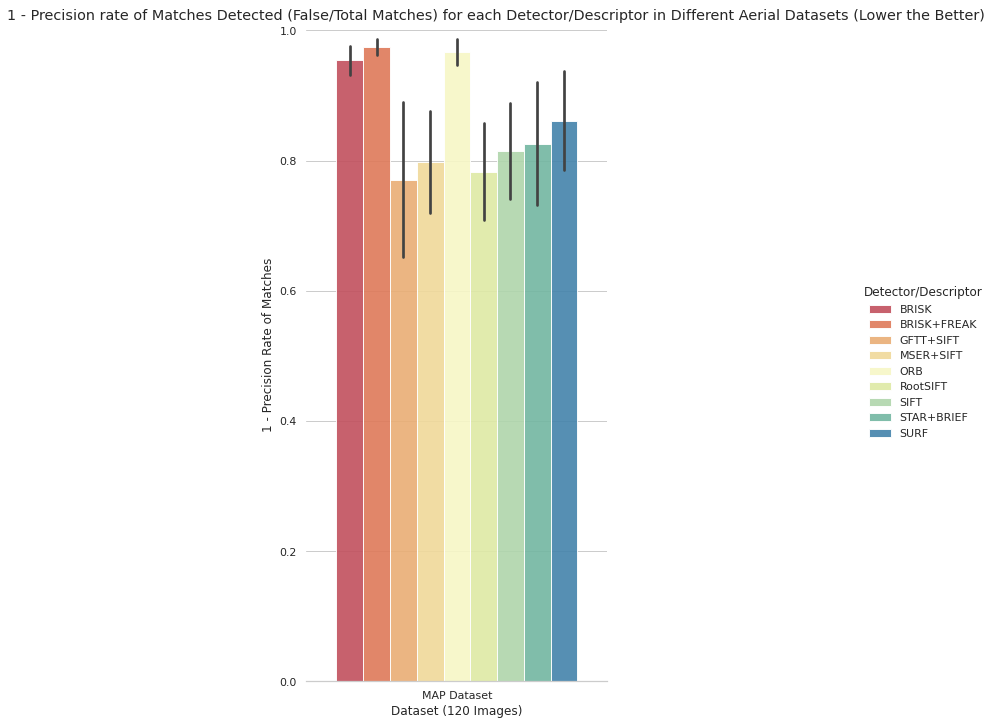

In [117]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_6.png')

F-Score for each Detector+Descriptor

In [118]:
df_match_9['F-Score'] = (2* (1 - df_match_9['1 - Precision Rate of Matches']) * df_match_9['Recall Rate of Matches'])/((1 - df_match_9['1 - Precision Rate of Matches']) + df_match_9['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

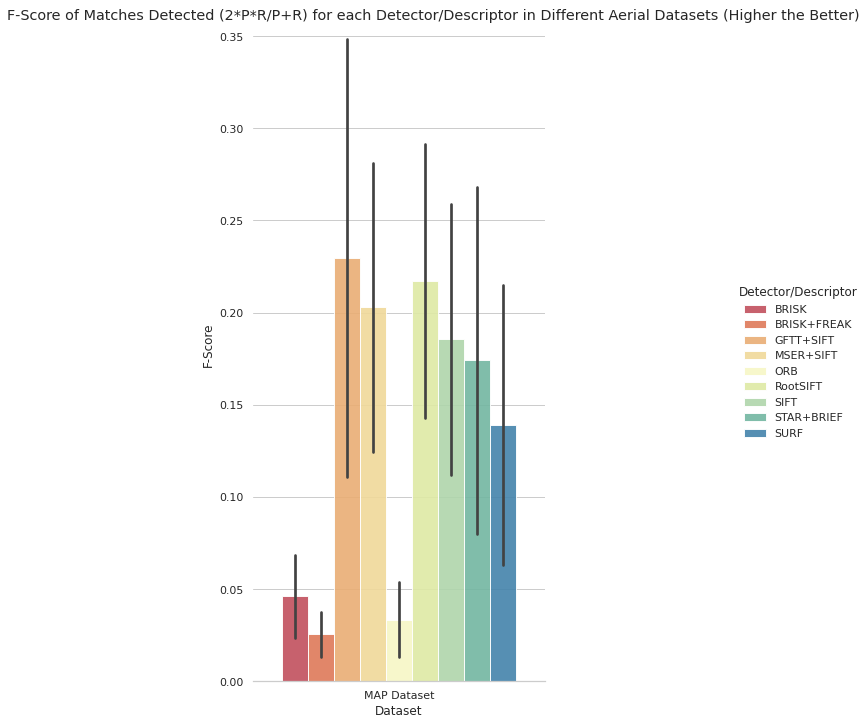

In [119]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_6.png')

In [120]:
df_match_9.to_csv('drive/MyDrive/All_metrics_9.csv')

Time for each Detector+Descriptor

In [123]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[7]] + [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[8]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['GFTT+SIFT']*(1) + ['MSER+SIFT']*(1) + ['ORB']*(1) +['RootSIFT']*(1) +['SIFT']*(1) + ['STAR+BRIEF']*(1) + ['SURF']*(1)}
df_time_9 = pd.DataFrame(data=d)

In [124]:
print(df_time_9)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  321.807181               BRISK
1  MAP Dataset  141.556306         BRISK+FREAK
2  MAP Dataset  151.774228           GFTT+SIFT
3  MAP Dataset   29.136064           MSER+SIFT
4  MAP Dataset  380.321776                 ORB
5  MAP Dataset   27.201628            RootSIFT
6  MAP Dataset  367.458421                SIFT
7  MAP Dataset   27.614021          STAR+BRIEF
8  MAP Dataset  817.820683                SURF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

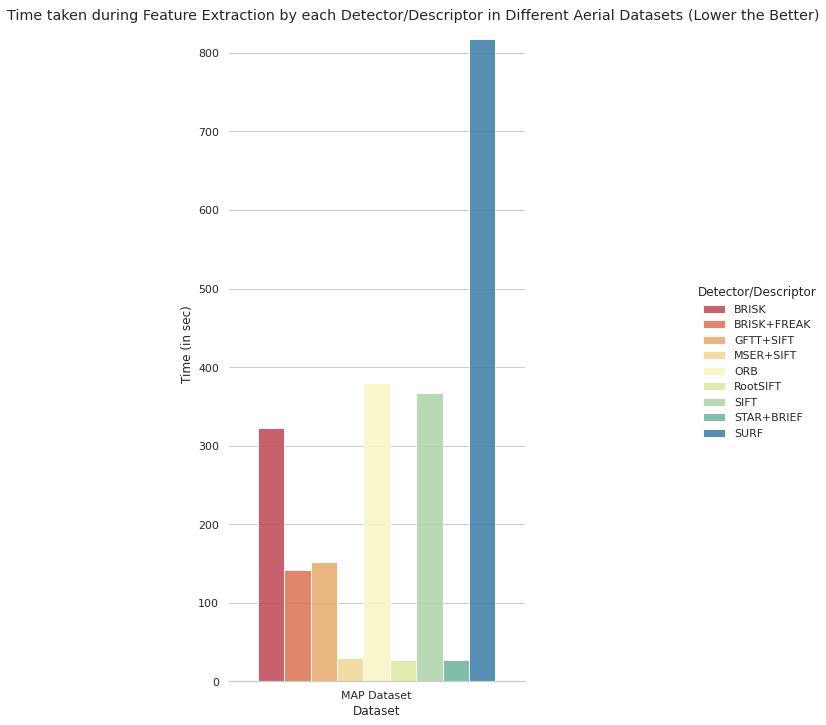

In [125]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_9, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_6.png')

In [126]:
df_time_9.to_csv('drive/MyDrive/Time_9.csv')

Stitching with CPU